In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob

"""Change to the data folder"""
new_path = "./new_val_in/new_val_in/"

# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

### Create a dataset class 

In [2]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
val_dataset  = ArgoverseDataset(data_path=new_path)

In [3]:
val_dataset[0] # 0.pkl

{'city': 'PIT',
 'lane': array([[1734.5114 ,  352.962  ,    0.     ],
        [1739.607  ,  357.24536,    0.     ],
        [1744.7026 ,  361.52872,    0.     ],
        [1749.7982 ,  365.81207,    0.     ],
        [1754.9087 ,  370.0777 ,    0.     ],
        [1760.024  ,  374.33743,    0.     ],
        [1765.1394 ,  378.59717,    0.     ],
        [1770.2549 ,  382.85687,    0.     ],
        [1775.3702 ,  387.1166 ,    0.     ],
        [1710.8209 ,  332.3826 ,    0.     ],
        [1711.33   ,  332.89383,    0.     ],
        [1711.839  ,  333.40506,    0.     ],
        [1712.348  ,  333.9163 ,    0.     ],
        [1712.8673 ,  334.41647,    0.     ],
        [1713.3953 ,  334.90735,    0.     ],
        [1713.923  ,  335.39844,    0.     ],
        [1714.4508 ,  335.8895 ,    0.     ],
        [1714.9785 ,  336.38055,    0.     ],
        [1708.9468 ,  335.1543 ,    0.     ],
        [1709.4783 ,  335.65274,    0.     ],
        [1710.0099 ,  336.15118,    0.     ],
        [1

In [4]:
from sklearn.linear_model import LinearRegression
import csv

In [96]:
out_X = []
out_Y = []

In [111]:
for pkl in val_dataset:
    train_X = []
    train_Xy = []
    train_Y = []
    train_Yy = []
    agent_idx = 0
    for i in range(60):
        if pkl['track_id'][i][0][0] == pkl['agent_id']:
            agent_idx = i
            break
    for i in range(18):
        x = pkl['p_in'][agent_idx][i][0]
        y = pkl['p_in'][agent_idx][i][1]
        v_x = pkl['v_in'][agent_idx][i][0]
        v_y = pkl['v_in'][agent_idx][i][1]
        x_out = pkl['p_in'][agent_idx][i+1][0]
        y_out = pkl['p_in'][agent_idx][i+1][1]
        
        train_X.append([x,v_x,1])
        train_Xy.append(x_out)
        train_Y.append([y,v_y,1])
        train_Yy.append(y_out)
    
    regX = LinearRegression().fit(train_X, train_Xy)
    regY = LinearRegression().fit(train_Y, train_Yy)
    
    out_x = [0] * 30
    out_y = [0] * 30
    v_x = pkl['v_in'][agent_idx][18][0]
    v_y = pkl['v_in'][agent_idx][18][1]
    out_x[0] = regX.predict([[pkl['p_in'][agent_idx][18][0],v_x,1]])[0]
    out_y[0] = regY.predict([[pkl['p_in'][agent_idx][18][1],v_y,1]])[0]
    for i in range(29):
        out_x[i+1] = regX.predict([[out_x[i],v_x,1]])[0]
        out_y[i+1] = regY.predict([[out_y[i],v_y,1]])[0]
    out_X.append(out_x)
    out_Y.append(out_y)

Write to file

In [131]:
with open('baseline.csv', mode='w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    title = ['0'] * 61
    title[0] = 'ID'
    for i in range(60):
        title[i+1] = 'v' + str(i+1)
    writer.writerow(title)
    
    for i in range(3200):
        row = [0] * 61
        row[0] = val_dataset[i]['scene_idx']
        for j in range(30):
            row[j*2+1] = out_X[i][j]
            row[j*2+2] = out_Y[i][j]
        writer.writerow(row)

### Create a loader to enable batch processing

In [9]:
batch_sz = 4

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]
    inp = torch.LongTensor(inp)
    out = torch.LongTensor(out)
    return [inp, out]

val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=0)

### Visualize the batch of sequences

<ipython-input-9-e34a6e23e746>:7: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  inp = torch.LongTensor(inp)
<ipython-input-9-e34a6e23e746>:8: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  out = torch.LongTensor(out)


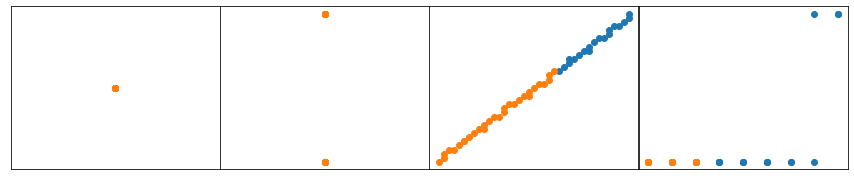

In [10]:
import matplotlib.pyplot as plt
import random

agent_id = 0

def show_sample_batch(sample_batch, agent_id):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])
        axs[i].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])

        
for i_batch, sample_batch in enumerate(val_loader):
    inp, out = sample_batch
    """TODO:
      Deep learning model
      training routine
    """
    show_sample_batch(sample_batch, agent_id)
    break